In [863]:
import matplotlib.pyplot as plt
import pandas as pd

import os
import numpy as np
import time
from scipy.signal import correlate, find_peaks
from collections import defaultdict

In [1114]:
data_path  = r'C:\Users\lhauptmann\Code\WristPPG2\data'
save_dir = r'C:\Users\lhauptmann\Code\WristPPG2\data\dataset'
index = 261
participant_name = "alex_2"

imu_file = f"imu_{index:03d}.txt"
ppg_file = f"ppg_{index:03d}.txt"
label_file = f"labels//label_{index:03d}.csv"
video_file = f"webcam_recordings//webcam_{index:03d}.avi"

LETTER_GESTURES = {
    "a": "Swipe Forward",
    "b": "Swipe Backward",
    "c": "Swipe Left",
    "d": "Swipe Right",
    "p": "Fast Pinch",
    "prr": "Rotate Right",
    "prl": "Rotate Left",
    "pbd": "Back to Default",
    "pc": "Pinch Hold",
    "po": "Pinch Open",
    "sp": "Side Pinch",
    "o": "Nothing",
    "s": "Knock"
}

sampling_rate_imu = 112.22
sampling_rate_ppg = 112.345

In [1115]:

def read_ppg_csv(data_file, columns = None):
    df = pd.read_csv(data_file, skiprows=32, skipfooter=5, usecols=[0]+list(range(34,69)))
    df["timestamp"] = df["timestamp"]/1000
    df[["ACCX", "ACCY", "ACCZ"]] = df[["ACCX", "ACCY", "ACCZ"]] / 1000
    
    if columns is not None:
        df.rename(columns={col:el for i,(el, col) in enumerate(zip(columns, df.columns))}, inplace=True)
        
    # read all lines in the file
    with open(data_file, "r") as f:
        lines = f.readlines()
    start_time, end_time = None, None    
    for line in lines:
        if line.startswith("start time"):
            start_time = float(line.split(",")[-1])
        if line.startswith("stop_time"):
            end_time = float(line.split(",")[-1])
    
    return df, start_time, end_time

def read_txt_data(data_file, n_features = 9, columns = None, add_package_ids = None, add_package_id_lengths = None):

    data = open(data_file, "r").read()

    rows = data.strip().split("\n")

    def pad_to_longest(package_dict, padding_value=0):
        el_length = sorted(package_dict.items(), key=lambda x: len(x[1]))[::-1]
        longest = len(el_length[0][1])
        shortest = len(el_length[-1][1])
        print(f"Padding by {longest - shortest} elements")

        print(f"Longest element: {el_length[0][0]} with length {longest}")
        print(f"Shortest element: {el_length[-1][0]} with length {shortest}")
        print(f"Second shortest element: {el_length[-2][0]} with length {len(el_length[-2][1])}")
        for k in package_dict.keys():
            package_dict[k] += [padding_value] * (longest - len(package_dict[k]))
        return package_dict

    def update_dict(data_dict, package_dict, package_id=None):
        longest_package_length = min([len(v) for v in package_dict.values()])
        if package_id is not None:
            package_dict["package_id"] = [package_id] * longest_package_length
        
        for k in package_dict.keys():
            data_dict[k].extend(package_dict[k])
        return data_dict


    data_dict = {k:[] for k in range(0,n_features)}
    data_dict["package_id"] = []
    package_dict = {k:[] for k in range(0,n_features)}
    # Loop over each row
    package_id = 0
    previous_key = 100
    start_time = 0
    end_time = 0
    for row in rows:
        if row.startswith('start time'):
            start_time = float(row.split(":")[-1])
            continue
        if row.startswith('end time'):
            end_time = float(row.split(":")[-1])
            continue
        # Split the row by spaces and convert each entry to an integer
        row_split = row.split(" ")
        key = int(row_split[0])  
        data_values = [float(el) for el in row_split[1:] if el != ""]
        if key < previous_key: # next package
            #package_dict = pad_to_longest(package_dict, padding_value=np.nan)
            data_dict = update_dict(data_dict, package_dict, package_id)
            
            package_id += 1
            if add_package_ids:
                for add_package_id,add_package_id_length in zip(add_package_ids, add_package_id_lengths):
                    if add_package_id == package_id:
                        # adds and empty package at this point
                        empty_package_length = add_package_id_length if add_package_id_length else len(package_dict[0])
                        empty_package_dict = {k:[np.nan] * empty_package_length for k in range(0,n_features)}
                        data_dict = update_dict(data_dict, empty_package_dict, package_id)
                        package_id += 1
            
            package_dict = {k:[] for k in range(0,n_features)}
                
            
        package_dict[key].extend(data_values)
        previous_key = key
    #return None, start_time, end_time, data_dict, package_dict
    data_dict = pad_to_longest(data_dict, padding_value=np.nan)
    
    df_data = pd.DataFrame(data_dict)
    if columns is not None:
        df_data.rename(columns={i:el for i,el in enumerate(columns)}, inplace=True)
    return df_data, start_time, end_time, data_dict


In [1116]:
ppg_columns = ["ppg_green_1", "ppg_green_2", "ppg_green_3", "ppg_green_4", "ppg_green_5", "ppg_green_6", "ppg_green_7", "ppg_green_8",
               "ppg_ir_1", "ppg_ir_2","ppg_ir_3", "ppg_ir_4","ppg_ir_5", "ppg_ir_6","ppg_ir_7", "ppg_ir_8", 
               #"ppg_red_1", "ppg_red_2","ppg_red_3", "ppg_red_4","ppg_red_5", "ppg_red_6","ppg_red_7", "ppg_red_8", 
               #"ppg_amb_1", "ppg_amb_2","ppg_amb_3", "ppg_amb_4","ppg_amb_5", "ppg_amb_6","ppg_amb_7", "ppg_amb_8", 
               "acc_ppg_x", "acc_ppg_y", "acc_ppg_z", 
               "timestamp"
               ]

add_package_id, add_package_id_length = None, None
if index == 87:
    add_package_id = [32, 149, 52]
    add_package_id_length = [245, 20, 10]
elif index == 89:
    add_package_id = [70]
    add_package_id_length = [60]
elif index == 46:
    add_package_id = [22, 47, 65]
    add_package_id_length = [250, 250, 22]
elif index == 71:
    add_package_id = [77, 101, 113, 123]
    add_package_id_length = [35, 20, 55, 10]
elif index == 40:
    add_package_id = [42,47]
    add_package_id_length = [28, 17]
elif index == 162:
    add_package_id = [125, 129]
    add_package_id_length = [130, 125]
elif index == 163:
    add_package_id = [96, 101]
    add_package_id_length = [125, 125]
elif index == 171:
    add_package_id = [75, 77, 80, 81, 90, 103]
    add_package_id_length = [120, 1, 20, 235, 130, 125]
elif index == 175:
    add_package_id = [76]
    add_package_id_length = [130]
elif index == 184:
    add_package_id = [41, 64, 69, 73, 76, 79, 82, 85, 90, 95, 102, 116, 123]
    add_package_id_length = [128, 125, 125, 130, 130, 130, 130, 130, 130, 125, 125, 125, 125]
elif index == 185:
    add_package_id = []
    add_package_id_length = []
elif index == 188:
    add_package_id = [177]
    add_package_id_length = [126]
elif index == 190:
    add_package_id = [37, 45, 53, 64, 70, 82, 93, 108, 126, 132, 158]
    add_package_id_length = [123, 123, 123, 123, 123, 123, 123, 123, 122, 125, 123]


df_ppg, ppg_start, ppg_end, ppg_dict = read_txt_data(os.path.join(data_path, ppg_file), n_features=len(ppg_columns), columns = ppg_columns, add_package_ids=add_package_id, add_package_id_lengths=add_package_id_length)

ppg_acc_factor = 4 if (index < 8 and index != 3) else 1
df_ppg[["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]] = df_ppg[["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]] * ppg_acc_factor



#print(f"Time of Recording: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(ppg_start))}")

Padding by 367 elements
Longest element: 19 with length 43609
Shortest element: package_id with length 43242
Second shortest element: 0 with length 43607


In [1117]:
imu_columns = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "timestamp", "timestamp_computer"]

df_imu, imu_start, imu_end, imu_dict = read_txt_data(os.path.join(data_path, imu_file), n_features=8, columns = imu_columns)

Padding by 0 elements
Longest element: package_id with length 43505
Shortest element: 0 with length 43505
Second shortest element: 1 with length 43505


In [1118]:

#df_ppg.dropna(inplace=True)

if df_imu["timestamp"].duplicated().any():
    n_duplicates = df_imu["timestamp"].duplicated().sum()
    print(f"Found {n_duplicates} duplicates in the imu data")
    df_imu.drop_duplicates(subset="timestamp", inplace=True)
df_imu.dropna(subset=["timestamp"], inplace=True)
df_imu.set_index("timestamp", inplace=True)
df_imu.interpolate(inplace=True, method="slinear")
df_imu.reset_index(inplace=True)

if index == 60:
    outlier_index = df_imu["timestamp"].diff().idxmin()
    df_imu.loc[outlier_index,"timestamp"] = pd.NA
    df_imu["timestamp"] = df_imu["timestamp"].interpolate()
# setting the imu timestamp to match the ppg timestamp

if index in [123, 124, 125, 126]:
    df_imu_new = df_imu.copy()
    df_imu_new["acc_x"] = -df_imu["acc_y"]
    df_imu_new["acc_y"] = -df_imu["acc_x"]
    df_imu_new["acc_z"] = -df_imu["acc_z"]
    df_imu_new["gyro_x"] = -df_imu["gyro_y"]
    df_imu_new["gyro_y"] = -df_imu["gyro_x"]
    df_imu_new["gyro_z"] = -df_imu["gyro_z"]
    df_imu = df_imu_new

if index == 100: # funny jumps in the imu timestamp
    df_imu = df_imu[df_imu["timestamp"] >= df_imu["timestamp"].mean()]


if (df_imu["timestamp"].diff() < -1000).any(): # most likely overflow in timestamp counter
    
    jump = df_imu["timestamp"].diff().idxmin()
    df_imu.loc[jump:,"timestamp"] = df_imu.loc[jump:,"timestamp"] + 2**24


df_imu["timestamp"] = (df_imu["timestamp"] - df_imu["timestamp"].iloc[0])/1000 + imu_start

#df_imu["timestamp"].diff().hist(bins=100, log=True)


In [1119]:
labels = pd.read_csv(os.path.join(data_path, label_file))
labels.sort_values("start_time", inplace=True)
#labels = pd.read_csv(os.path.join(data_path, label_file.replace(".csv", "_corrected.csv")))

In [1120]:
current_package_timestamp = ppg_start
current_timestamp = ppg_start



df_ppg["package_id"] = df_ppg["package_id"].ffill()
df_ppg[df_ppg.columns.difference(["timestamp", "package_id"])] = df_ppg[df_ppg.columns.difference(["timestamp", "package_id"])].rolling(window=3).median()
df_ppg.interpolate(inplace=True)


In [1121]:
def mean_acc_corr(df_ppg, df_imu):
    # best is 112.3 Hz for sampling_rate_ppg
    
    calibration_peaks_imu = find_peaks(df_imu["acc_z"] - df_imu["acc_z"].mean(), height=8, prominence=8, distance=100)
    calibration_peaks_ppg = find_peaks(df_ppg["acc_ppg_z"] - df_ppg["acc_ppg_z"].mean(), height=8, prominence=8, distance=100)
    #print(calibration_peaks_imu)
    #print(calibration_peaks_ppg)

    imu_peak_index = 0
    ppg_peak_index = 0

    time_offset = df_ppg["timestamp"].iloc[calibration_peaks_ppg[0][ppg_peak_index]] - df_imu["timestamp"].iloc[calibration_peaks_imu[0][imu_peak_index]]
    df_ppg["timestamp"] = df_ppg["timestamp"] - time_offset
    
    df_imu_re = df_imu.dropna(inplace=False, subset="timestamp")
    df_imu_re = df_imu_re.set_index("timestamp")
    df_ppg_re = df_ppg.dropna(inplace=False, subset="timestamp")
    df_ppg_re = df_ppg.set_index("timestamp")
    df_imu_re = df_imu_re.reindex(df_imu_re.index.union(df_ppg_re.index))
    df_imu_re.interpolate(method='slinear', inplace=True, assume_sorted=False)
    df_imu_re = df_imu_re.reindex(df_ppg_re.index).dropna()
    df_ppg_re = df_ppg_re.reindex(df_imu_re.index)
    
    #ax = df_ppg_re["acc_ppg_x"].plot()
    #df_imu_re["acc_x"].plot(ax=ax)
    
    return np.mean([df_ppg_re["acc_ppg_z"].corr(df_imu_re["acc_z"]), df_ppg_re["acc_ppg_x"].corr(df_imu_re["acc_x"]), df_ppg_re["acc_ppg_y"].corr(df_imu_re["acc_y"])])



In [1122]:
result_dict = {}
for sampling_rate_ppg in np.linspace(112.1, 112.4, 30):

    current_package_timestamp = ppg_start
    current_timestamp = ppg_start

    df_ppg["timestamp"] = np.arange(ppg_start, ppg_start + 1/sampling_rate_ppg*(len(df_ppg) - 0.1), 1/sampling_rate_ppg)

    result_dict[sampling_rate_ppg] = mean_acc_corr(df_ppg, df_imu)
    
pd.Series(result_dict).sort_values(ascending=False)
sampling_rate_ppg = pd.Series(result_dict).idxmax()
print(f"Best sampling rate for PPG is {sampling_rate_ppg} with correlation {pd.Series(result_dict).max()}")

if index == 89:
    sampling_rate_ppg += 0.05

if index == 50:
    sampling_rate_ppg += 0.05
    
if index == 59:
    sampling_rate_ppg += 0.025
    
if index == 146:
    sampling_rate_ppg -= 0.05

    

Best sampling rate for PPG is 112.31724137931035 with correlation 0.9983522690571792


In [1123]:

df_ppg["timestamp"] = np.arange(ppg_start, ppg_start + 1/sampling_rate_ppg*(len(df_ppg) - 0.1), 1/sampling_rate_ppg)
df_ppg["package_id"] = df_ppg["package_id"].ffill()
df_ppg[df_ppg.columns.difference(["timestamp", "package_id"])] = df_ppg[df_ppg.columns.difference(["timestamp", "package_id"])].rolling(window=3).median()
df_ppg.interpolate(inplace=True)



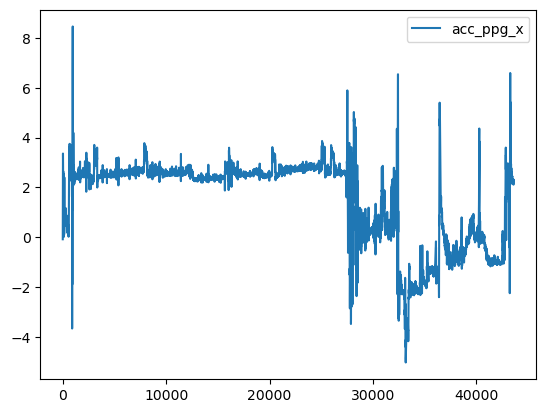

In [1124]:
# plot where the nans are
ax = df_ppg.plot(y="acc_ppg_x")
#df_ppg[df_ppg["acc_ppg_x"].isna()].plot(x="timestamp", y="acc_ppg_x", ax=ax, style="o")

In [1125]:
# looking for calibration peaks to match the data


calibration_peaks_imu = find_peaks(df_imu["acc_z"] - df_imu["acc_z"].mean(), height=8, prominence=8, distance=100)
calibration_peaks_ppg = find_peaks(df_ppg["acc_ppg_z"] - df_ppg["acc_ppg_z"].mean(), height=8, prominence=8, distance=100)
print(calibration_peaks_imu)
print(calibration_peaks_ppg)



(array([  932, 27996, 32411, 43174], dtype=int64), {'peak_heights': array([15.46045677,  8.86038169, 10.83567405, 15.46045677]), 'prominences': array([15.26884827, 13.58155701, 17.61237488, 14.77906677]), 'left_bases': array([  910, 25298, 25298, 25298], dtype=int64), 'right_bases': array([25298, 31788, 32448, 43211], dtype=int64)})
(array([  911, 28018, 32440, 43220], dtype=int64), {'peak_heights': array([28.21695464,  8.23174957, 10.90425933, 18.5533316 ]), 'prominences': array([28.18935547, 12.88164063, 17.78164063, 17.94912109]), 'left_bases': array([  889, 25318, 25318, 25318], dtype=int64), 'right_bases': array([25317, 31816, 32477, 43257], dtype=int64)})


In [1126]:
imu_peak_index = 0
ppg_peak_index = 0

time_offset = df_ppg["timestamp"].iloc[calibration_peaks_ppg[0][ppg_peak_index]] - df_imu["timestamp"].iloc[calibration_peaks_imu[0][imu_peak_index]]
print(time_offset)

df_ppg["timestamp"] = df_ppg["timestamp"] - time_offset

-0.20044422149658203


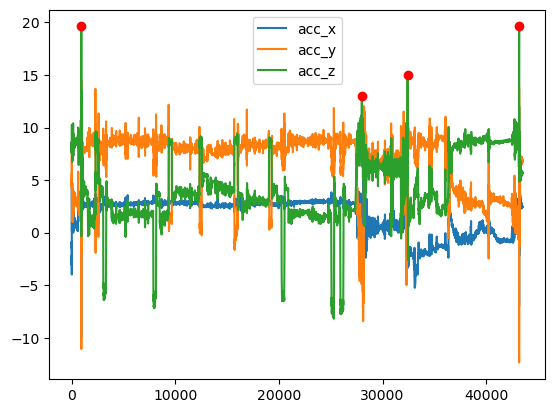

In [1127]:
ax = df_imu.plot( y=["acc_x", "acc_y", "acc_z"])
ax.plot(df_imu.iloc[calibration_peaks_imu[0]]["acc_z"], "ro")

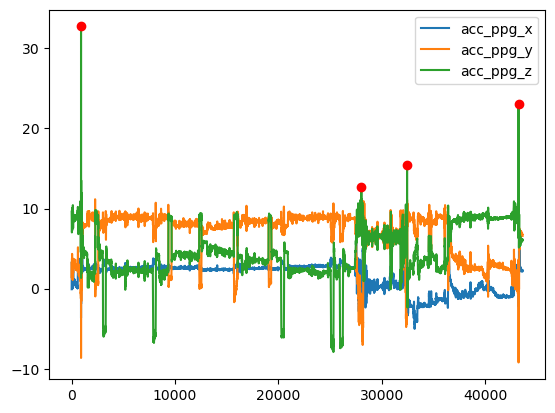

In [1128]:

ax = df_ppg.plot(y=["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"])
ax.plot(df_ppg.iloc[calibration_peaks_ppg[0]]["acc_ppg_z"], "ro")

In [1129]:
from scipy import signal

def resample_df(df, old_freq, new_freq, timestamp_col="timestamp"):
    """
    Resample the dataframe based on the given old and new frequency.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data to resample, with a timestamp column.
        timestamp_col (str): Name of the column containing timestamps.
        old_freq (float): Original sampling frequency in Hz.
        new_freq (float): Desired new sampling frequency in Hz.
        
    Returns:
        pd.DataFrame: Resampled DataFrame.
    """
    # Sort by timestamp to ensure order
    
    df = df.sort_values(by=timestamp_col).reset_index(drop=True)
    
    # Calculate the number of samples for the new frequency
    num_samples = int(len(df) * (new_freq / old_freq))
    
    # Generate a new time axis for resampling
    old_time = np.linspace(0, len(df) / old_freq, len(df))
    new_time = np.linspace(df[timestamp_col].iloc[0], df[timestamp_col].iloc[0] + len(df)  / old_freq, num_samples)
    
    # Resample each column except timestamp using scipy's resample
    resampled_data = {timestamp_col: new_time}
    for col in df.columns:
        if col != timestamp_col:
            resampled_data[col] = signal.resample(df[col].values, num_samples)
    
    return pd.DataFrame(resampled_data)


imu_resampled = resample_df(df_imu, sampling_rate_imu, sampling_rate_ppg)

<Axes: xlabel='timestamp'>

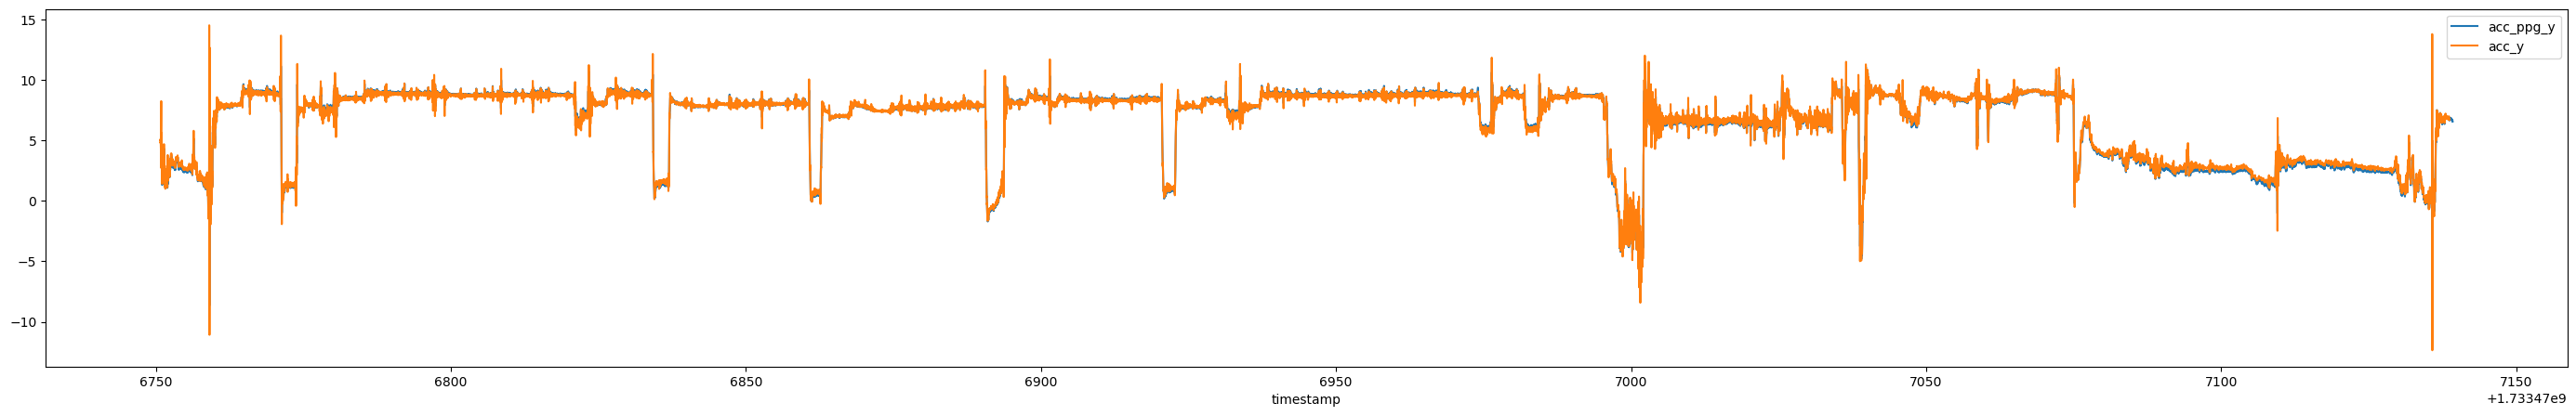

In [1130]:
fig, ax = plt.subplots(1, figsize=(35,5))
df_ppg.plot( y=["acc_ppg_y"], x="timestamp", ax=ax)

df_imu.plot( y=["acc_y"], x="timestamp",  ax=ax)

<Axes: xlabel='timestamp'>

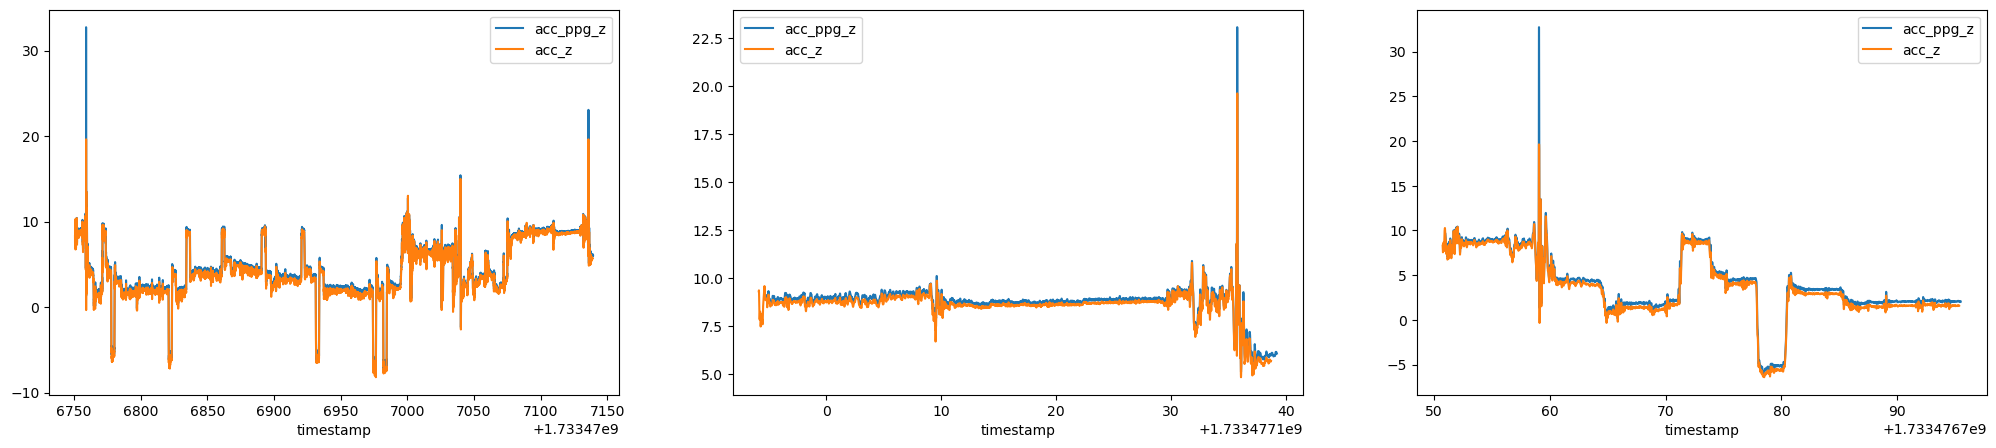

In [1131]:
fig, axes = plt.subplots(1,3, figsize=(25,5))
df_ppg.plot( y=["acc_ppg_z"], x = "timestamp", ax=axes[0])
df_imu.plot( y=["acc_z"], x = "timestamp", ax=axes[0])

df_ppg.iloc[:5000].plot(y=["acc_ppg_z"], x = "timestamp", ax=axes[2])
df_imu.iloc[:5000].plot(y=["acc_z"], x = "timestamp", ax=axes[2])
df_ppg.iloc[-5000:].plot(y=["acc_ppg_z"], x = "timestamp", ax=axes[1])
df_imu.iloc[-5000:].plot(y=["acc_z"], x = "timestamp", ax=axes[1])



In [1132]:
df_ppg.set_index("timestamp", inplace=True)
df_imu.dropna(inplace=True, subset="timestamp")
df_imu.set_index("timestamp", inplace=True)

In [1133]:
df_imu_re = df_imu.reindex(df_imu.index.union(df_ppg.index))
df_imu_re.interpolate(method='slinear', inplace=True, assume_sorted=False)
df_imu_re = df_imu_re.reindex(df_ppg.index).dropna()
df_ppg_re = df_ppg.reindex(df_imu_re.index)

In [1134]:
imu_mag = np.sqrt(df_imu_re["acc_z"]**2 + df_imu_re["acc_y"]**2 + df_imu_re["acc_x"]**2)
ppg_mag = np.sqrt(df_ppg_re["acc_ppg_z"]**2 + df_ppg_re["acc_ppg_y"]**2 + df_ppg_re["acc_ppg_x"]**2)
calibration_peaks_imu = find_peaks((imu_mag - imu_mag.mean()).abs(), height=5, prominence=6, distance=40)[0]
calibration_peaks_ppg = find_peaks((ppg_mag - ppg_mag.mean()).abs(), height=5, prominence=6, distance=40)[0]
calibration_peaks_ppg, calibration_peaks_imu

(array([  911, 32440, 43221], dtype=int64),
 array([  910, 32440, 43221], dtype=int64))

[  911 32440 43221] timestamp
1.733477e+09    32.730469
1.733477e+09    15.417773
1.733477e+09    23.066846
Name: acc_ppg_z, dtype: float64


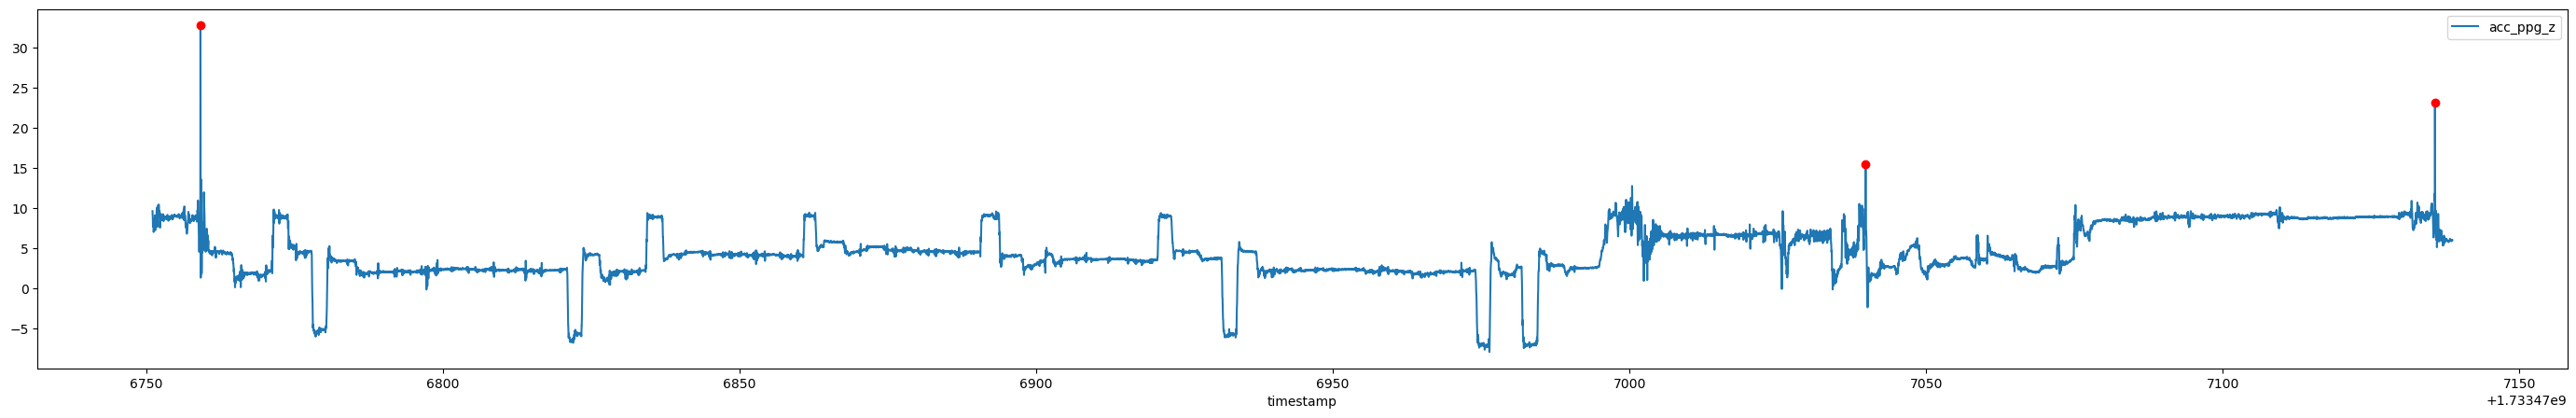

In [1135]:
# plot acc_ppg_z with peaks
fig, ax = plt.subplots(1, figsize=(35,5))
df_ppg_re.plot(y=["acc_ppg_z"], ax=ax)

ax.plot(df_ppg_re.iloc[calibration_peaks_ppg]["acc_ppg_z"], "ro")
print(calibration_peaks_ppg, df_ppg_re.iloc[calibration_peaks_ppg]["acc_ppg_z"])

In [1136]:
start_peak_id = 0
end_peak_id = -1
align_with = [
            'start', 
            'end'
              ]

In [1137]:
ppg_length = df_ppg_re.iloc[calibration_peaks_ppg[start_peak_id]].name - df_ppg_re.iloc[calibration_peaks_ppg[end_peak_id]].name
label_length = labels[labels["label"] == "s"]["start_time"].diff().iloc[-1]
ppg_length, label_length

(-376.697142124176, 376.7500479221344)

In [1138]:
specify_gestures = ["a", "b", "c", "d", "p", "po", "pc", "sp"]
labels = add_manual_labels(labels, data_path, video_file, specify_gestures=specify_gestures, delay_frames=-1, frame_offset= 10, fps=10)


C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_24072\3405922097.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinch_labels.sort_values(by=["label", "start_time"], inplace=True)


Corrected Start Time by -0.7538135051727295 and End Time by 0.24338793754577637
Corrected Start Time by -0.595038890838623 and End Time by 0.4731943607330322
Corrected Start Time by -0.6623413562774658 and End Time by 0.326261043548584
Corrected Start Time by -0.6881346702575684 and End Time by 0.10542821884155273
Corrected Start Time by -0.6779050827026367 and End Time by 0.25170278549194336
Corrected Start Time by -0.6863183975219727 and End Time by 0.3546183109283447
Corrected Start Time by -0.673107385635376 and End Time by 0.17821717262268066
Corrected Start Time by -0.7369539737701416 and End Time by 0.08525276184082031
Corrected Start Time by -0.8048553466796875 and End Time by 0.05672097206115723
Corrected Start Time by -0.6307046413421631 and End Time by 0.25087499618530273
Corrected Start Time by -0.5814566612243652 and End Time by 0.25380563735961914
Corrected Start Time by -0.732609748840332 and End Time by 0.13913750648498535
Corrected Start Time by -0.5943515300750732 and

In [1139]:
labels.to_csv(os.path.join(data_path, "labels" ,f"label_{index:03d}_corrected.csv"), index=False)

In [1140]:
labels.loc[labels["label"].isin(specify_gestures), ["start_time", "end_time"]] = labels.loc[labels["label"].isin(specify_gestures), ["start_time", "end_time"]] - 0.1

In [1141]:

for i in range(len(labels) - 1):
    index = labels.index[i]
    next_index = labels.index[i+1]
    end_time = labels.loc[index, "end_time"]
    next_start_time = labels.loc[next_index, "start_time"]
    if next_start_time < end_time + 0.1 and labels.loc[next_index, "label"] != "s":
        print(f"Overlap between {labels.loc[index, 'label']} and {labels.loc[next_index, 'label']}")
        print(f"End time of {labels.loc[index, 'label']}: {end_time}")
        print(f"Start time of {labels.loc[next_index, 'label']}: {next_start_time}")
        print(f"Time difference: {end_time - next_start_time}")
        labels.loc[next_index, "start_time"] = end_time + 0.1
    
    

Overlap between pbd and o
End time of pbd: 1733476822.6632757
Start time of o: 1733476822.6642764
Time difference: -0.0010006427764892578
Overlap between pbd and o
End time of pbd: 1733476862.5302436
Start time of o: 1733476862.531244
Time difference: -0.0010004043579101562
Overlap between o and o
End time of o: 1733476864.0125358
Start time of o: 1733476864.013536
Time difference: -0.0010001659393310547


In [499]:
labels = pd.read_csv(os.path.join(data_path,"labels" ,f"label_{index:03d}_corrected.csv"))

In [1142]:
labels_calibration_start_time = labels[labels["label"] == "s"].iloc[0]["start_time"]
labels_calibration_end_time = labels[labels["label"] == "s"].iloc[-1]["start_time"]
time_diff = []
if 'start' in align_with:
    time_diff.append(df_ppg_re.iloc[calibration_peaks_ppg[start_peak_id]].name - labels_calibration_start_time)
if 'end' in align_with:
    time_diff.append(df_ppg_re.iloc[calibration_peaks_ppg[end_peak_id]].name - labels_calibration_end_time)
print(time_diff)
time_diff = np.mean(time_diff)

labels_re = labels.copy()
labels_re[["start_time", "end_time"]] = labels[["start_time", "end_time"]] + time_diff

label_re = labels_re[labels_re["end_time"] < df_ppg_re.index[-1]]


if index <= 12 and not index == 8 and not index ==3:

    for i, row in labels_re.iterrows():
        if row["label"] == "s":
            continue
        previous_end_time = labels_re.iloc[i-1]["end_time"]
        start_time = max(row["start_time"] - 1.4, previous_end_time+0.1)
        labels_re.at[i, "start_time"] = start_time

[1.8649990558624268, 1.8120932579040527]


In [1143]:
df_all = pd.concat([df_imu_re, df_ppg_re], axis=1)

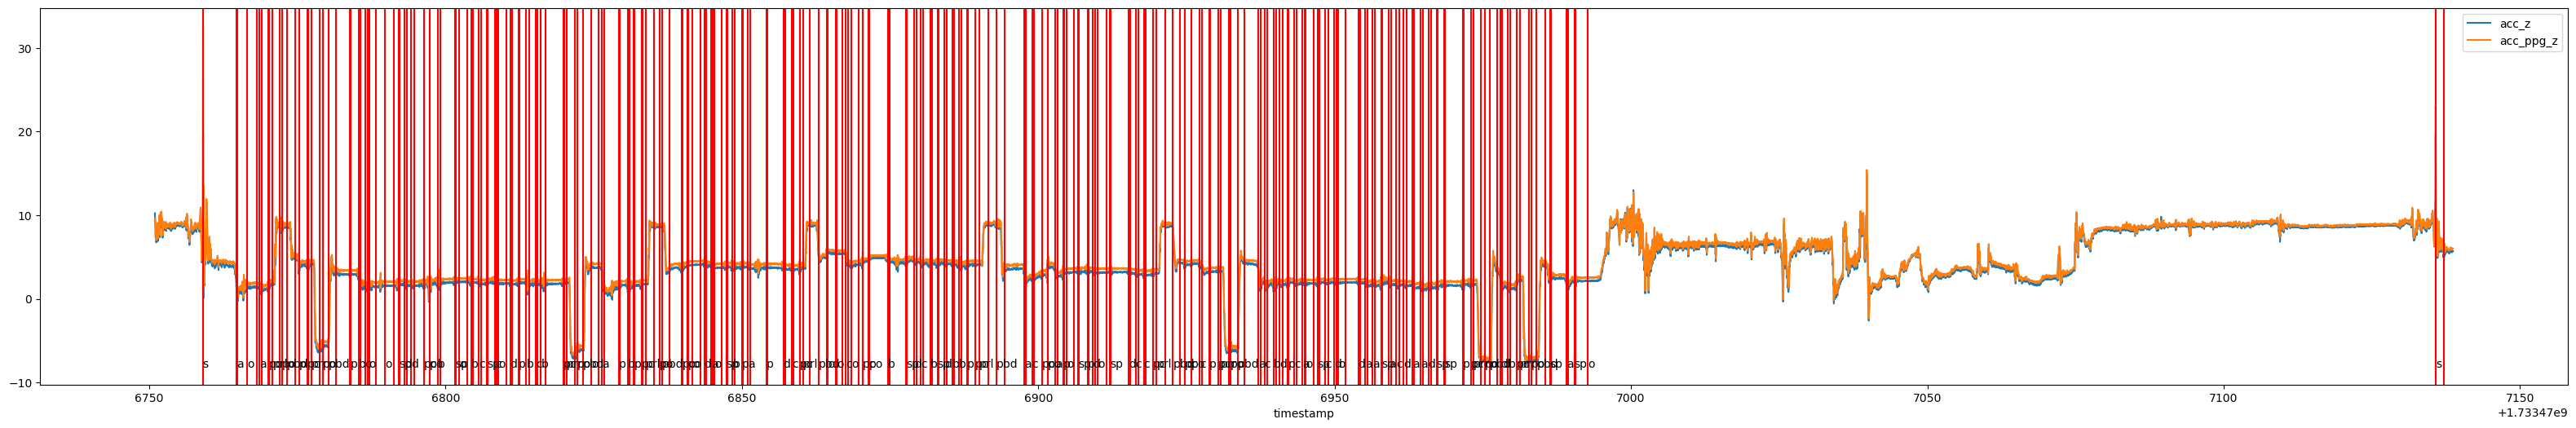

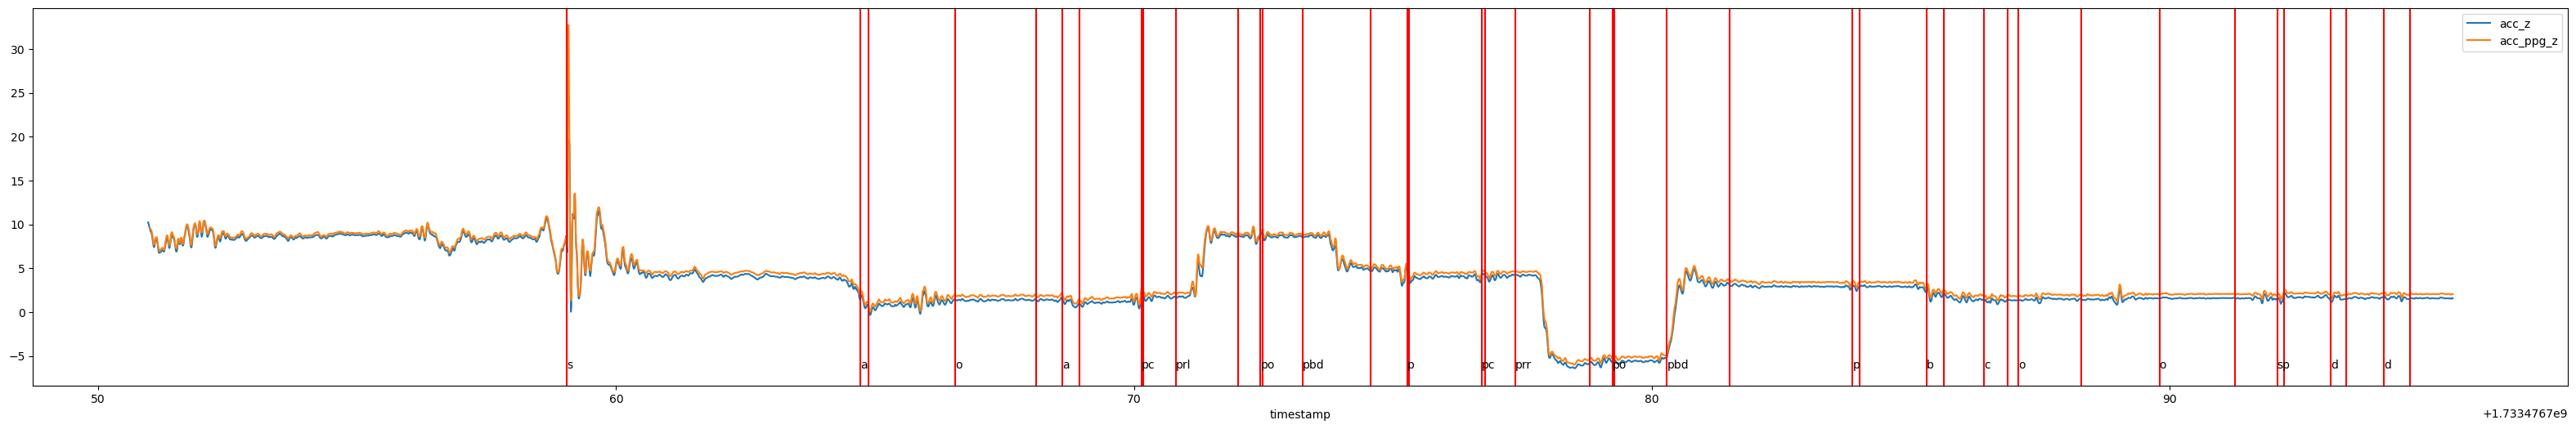

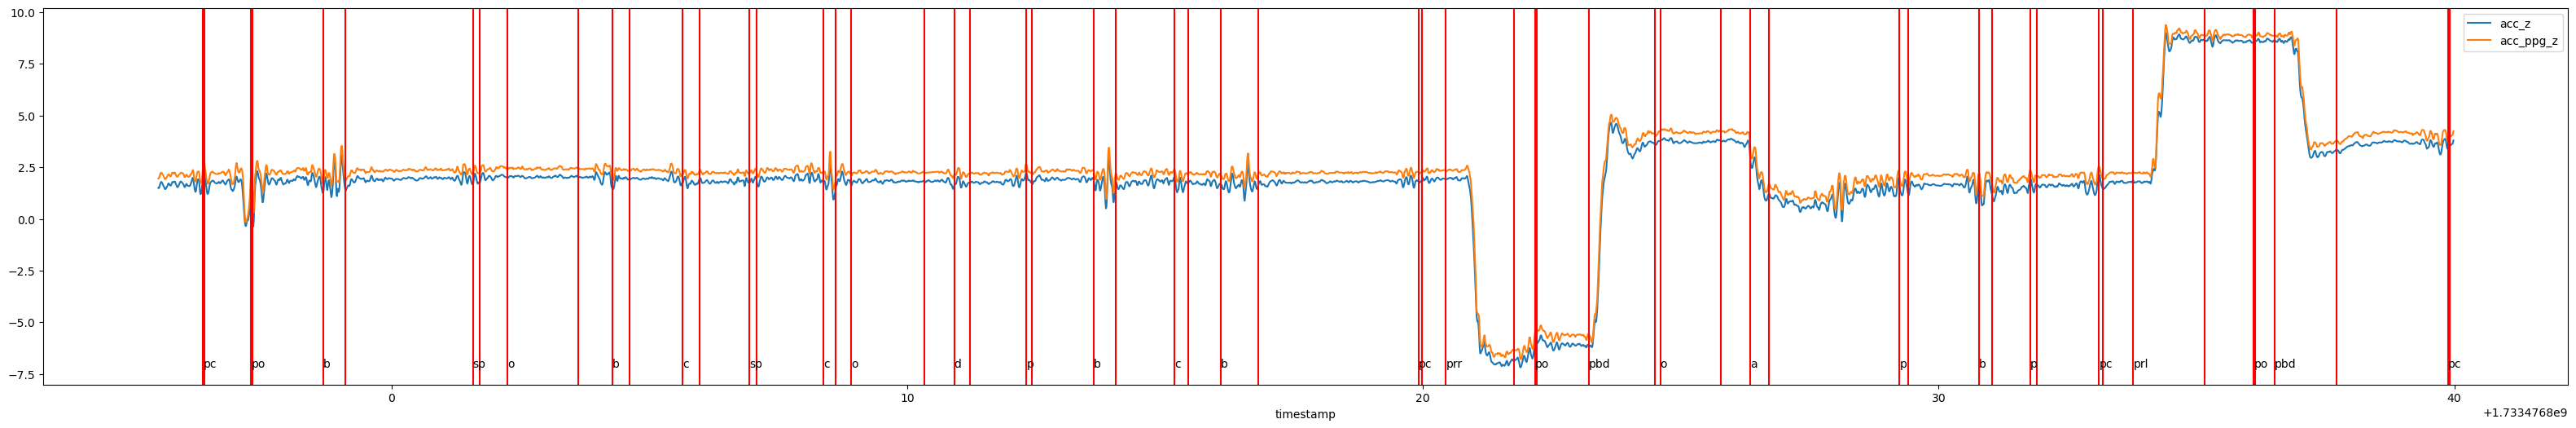

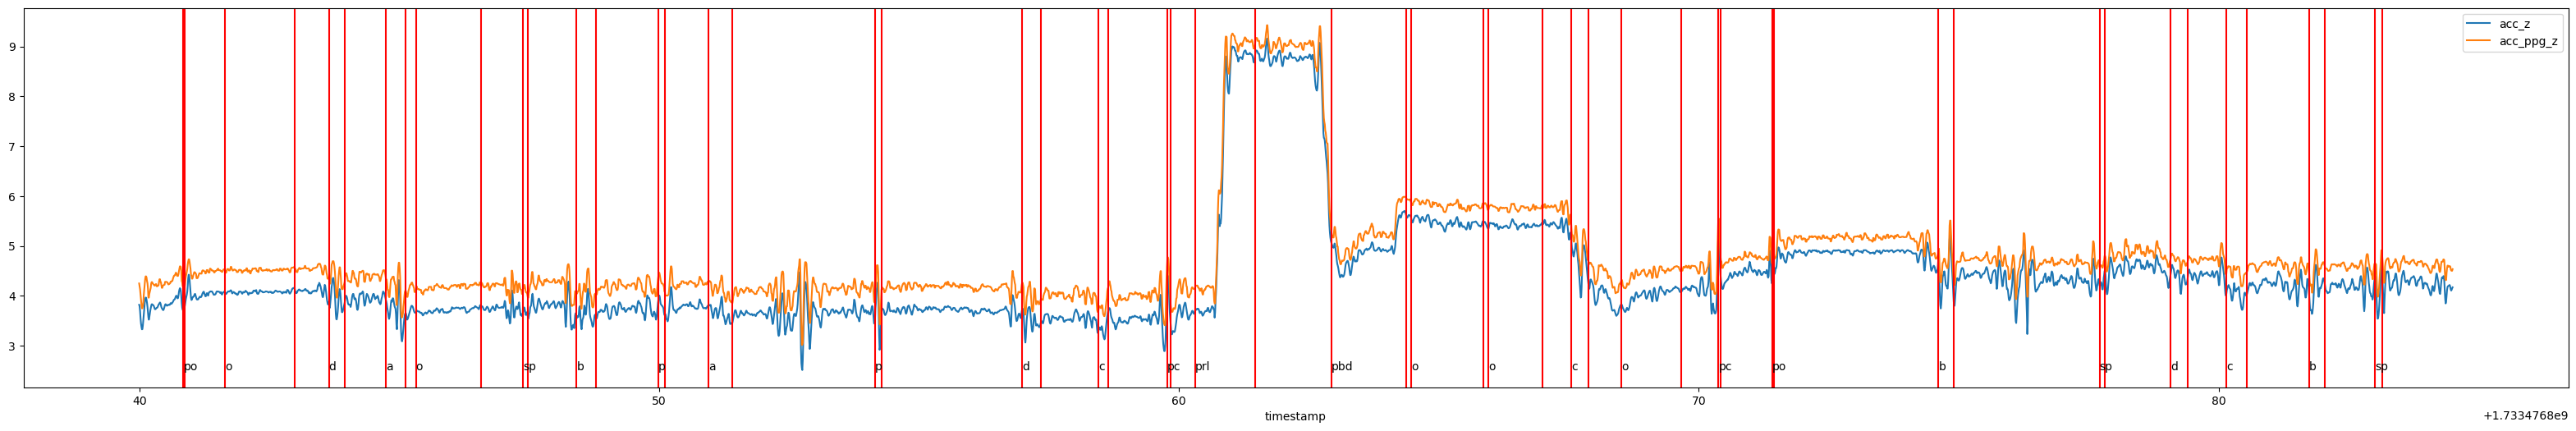

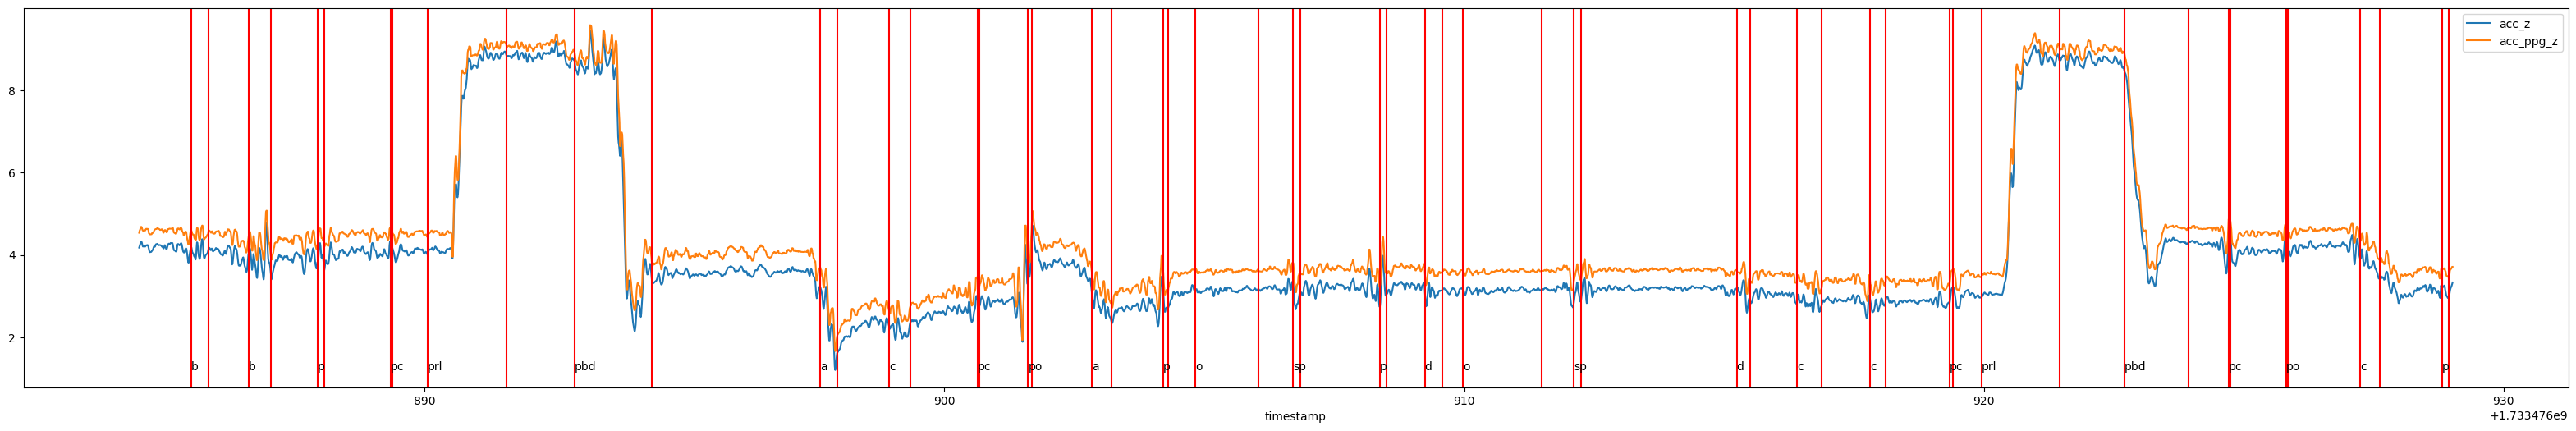

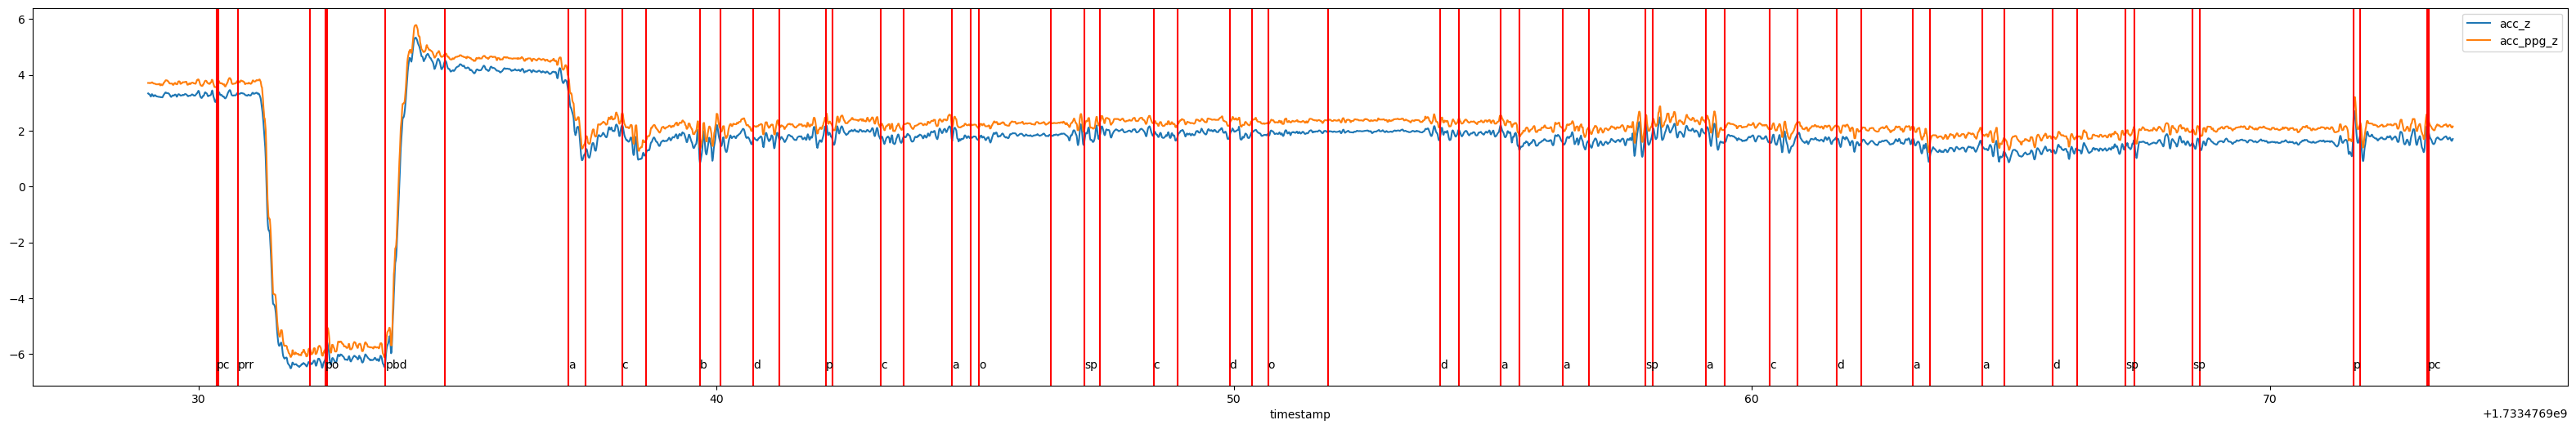

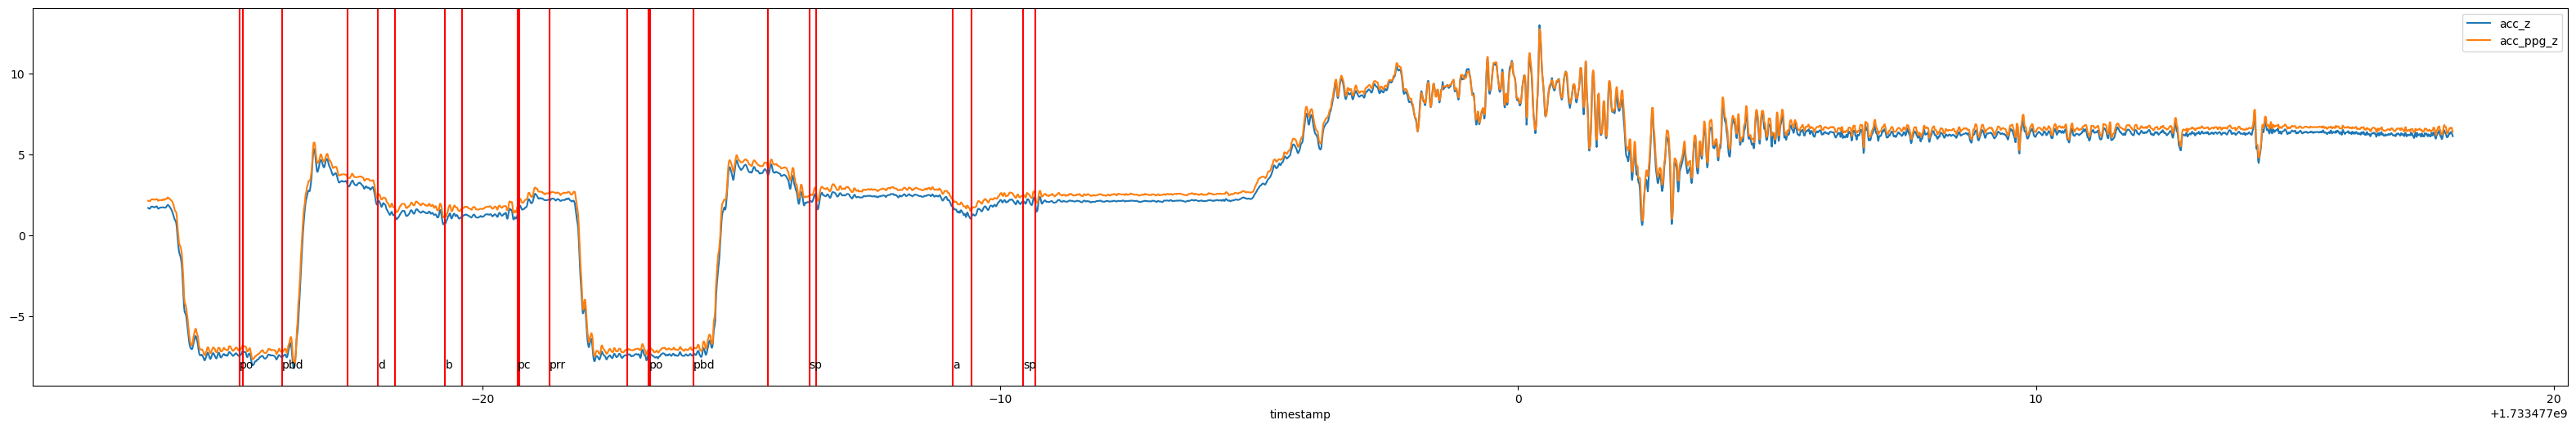

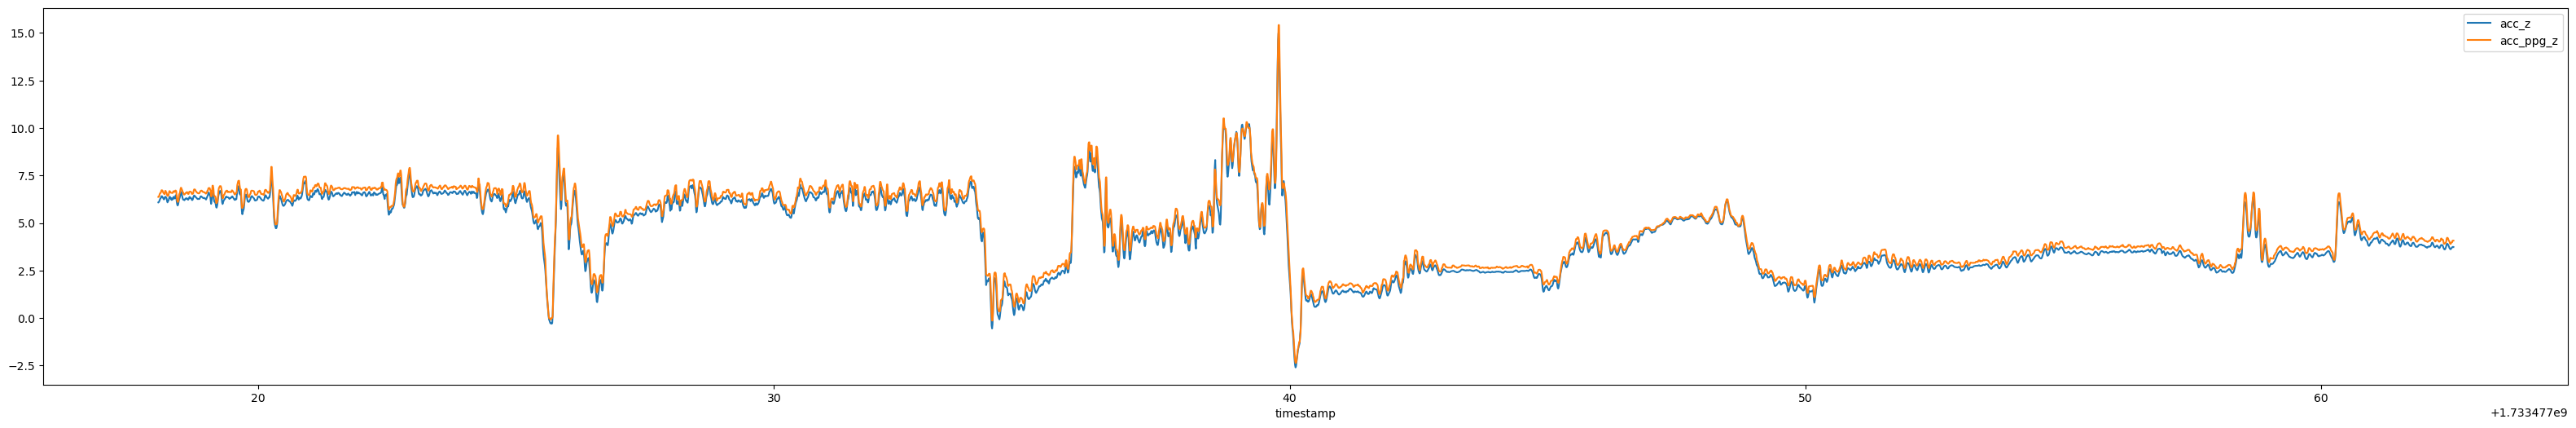

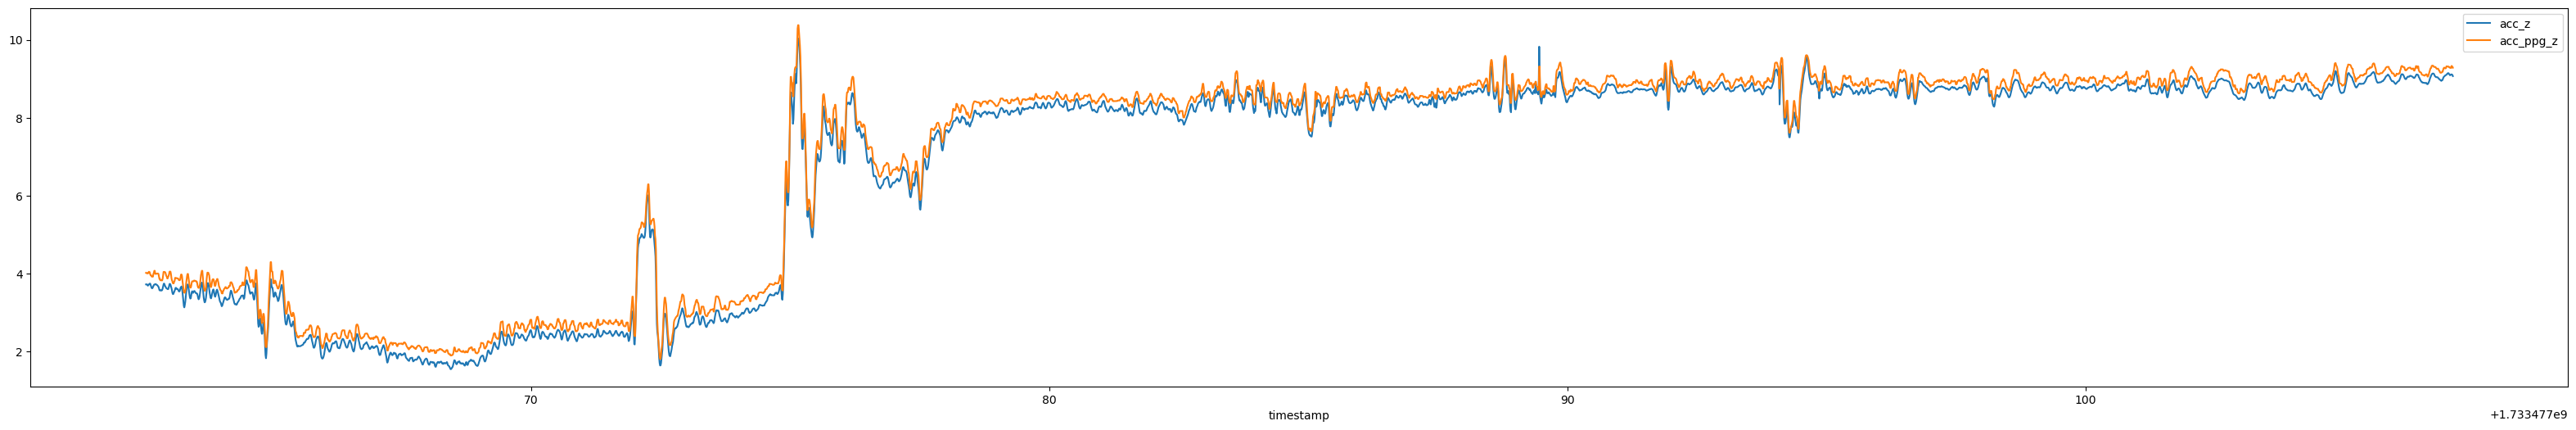

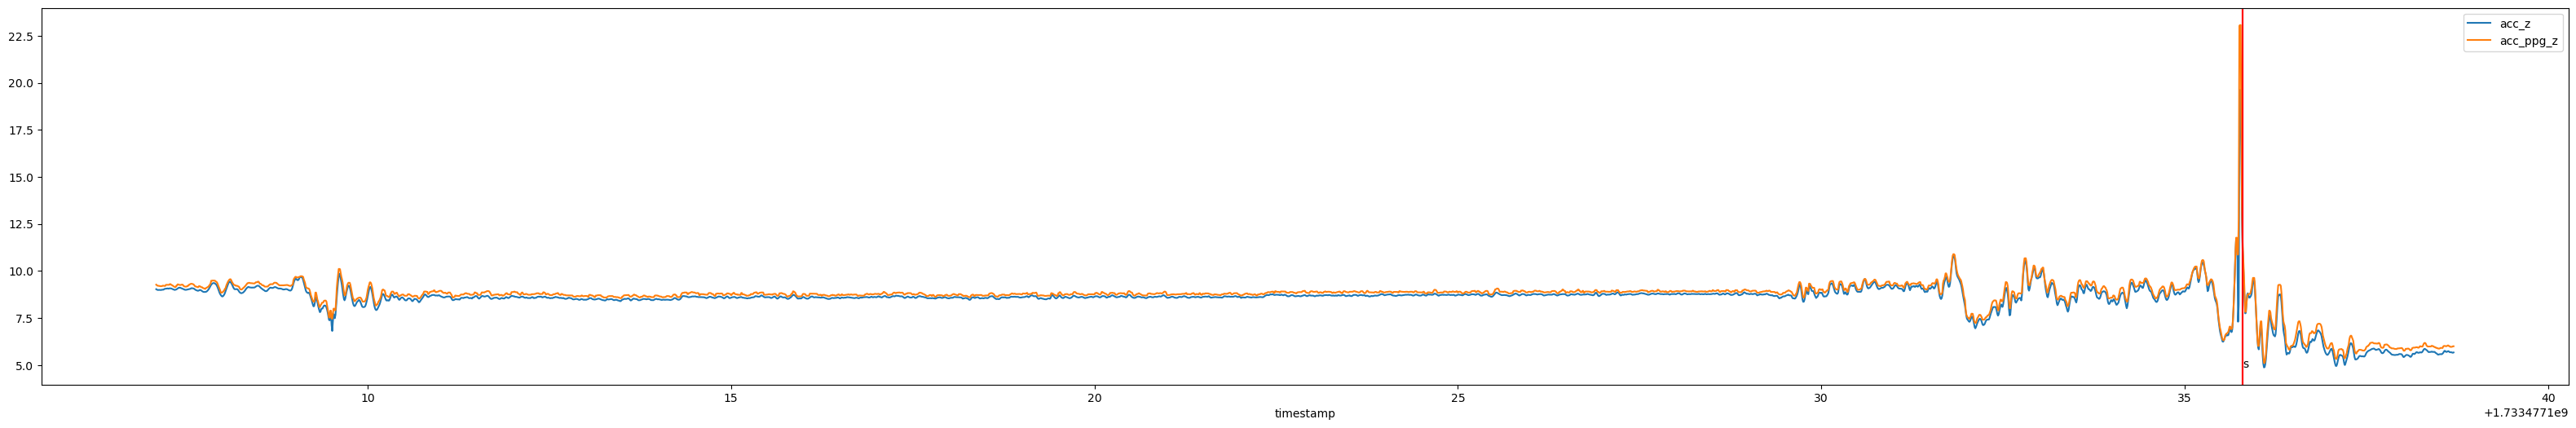

In [1144]:

def plot_with_labels(df ,labels):
    fig, ax = plt.subplots(figsize=(40, 6))
    df.plot(ax=ax)
    df_min = df.min().min() if isinstance(df, pd.DataFrame) else df.min()
    x_range = [df.index[0], df.index[-1]]
    for index, row in labels.iterrows():
        if row["start_time"] < x_range[0] or row["end_time"] > x_range[1]:
            continue
        ax.axvline(x=row["start_time"], color='r')
        ax.axvline(x=row["end_time"] , color='r')
        ax.text(row["start_time"] , df_min, row["label"], rotation=0)
    return ax

plot_with_labels(df_all[["acc_z", "acc_ppg_z"]], labels_re)
for i in range(0, len(df_all), 5000):
    plot_with_labels(df_all[["acc_z", "acc_ppg_z"]].iloc[i:i+5000], labels_re)


        

<Axes: xlabel='timestamp'>

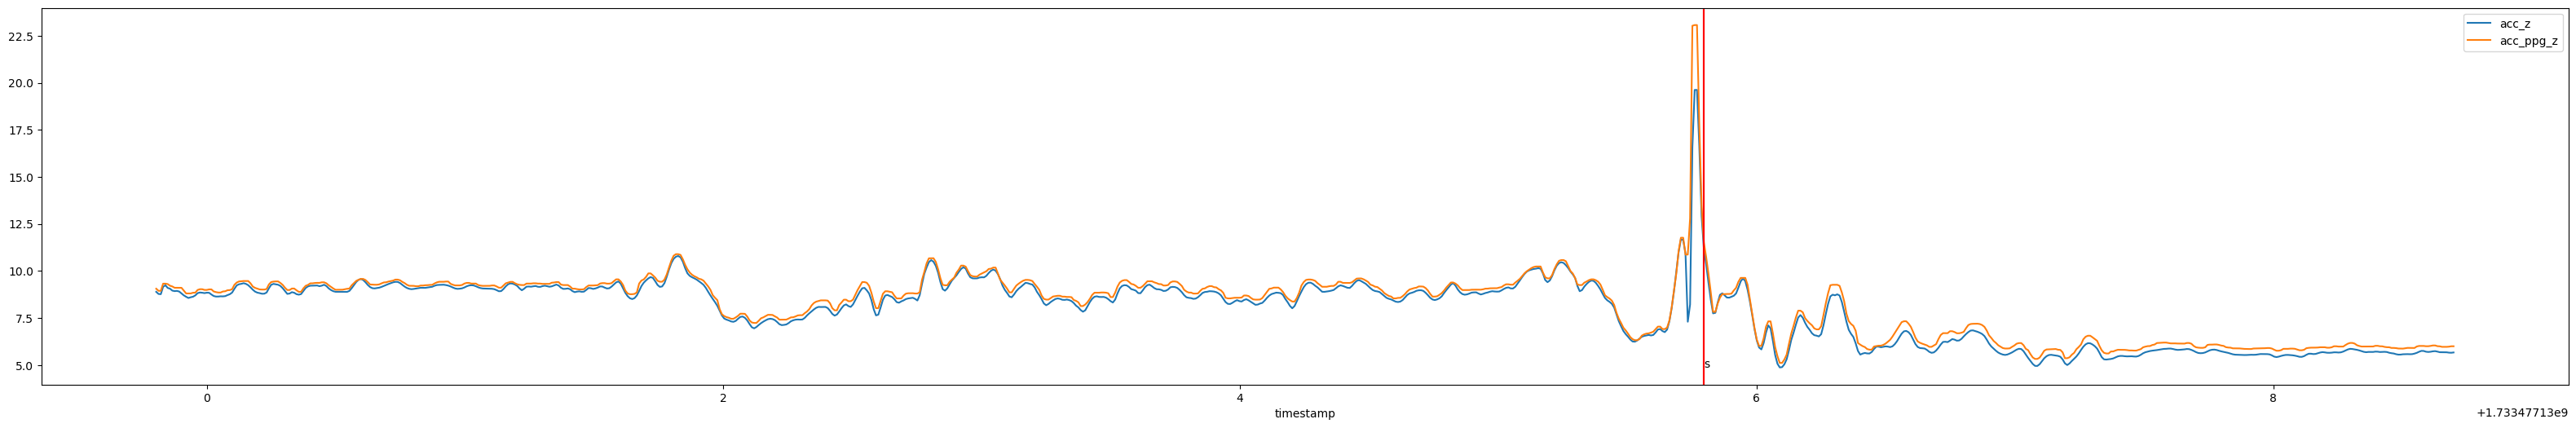

In [1145]:
plot_with_labels(df_all[["acc_z", "acc_ppg_z"]].iloc[-1000:], labels_re)

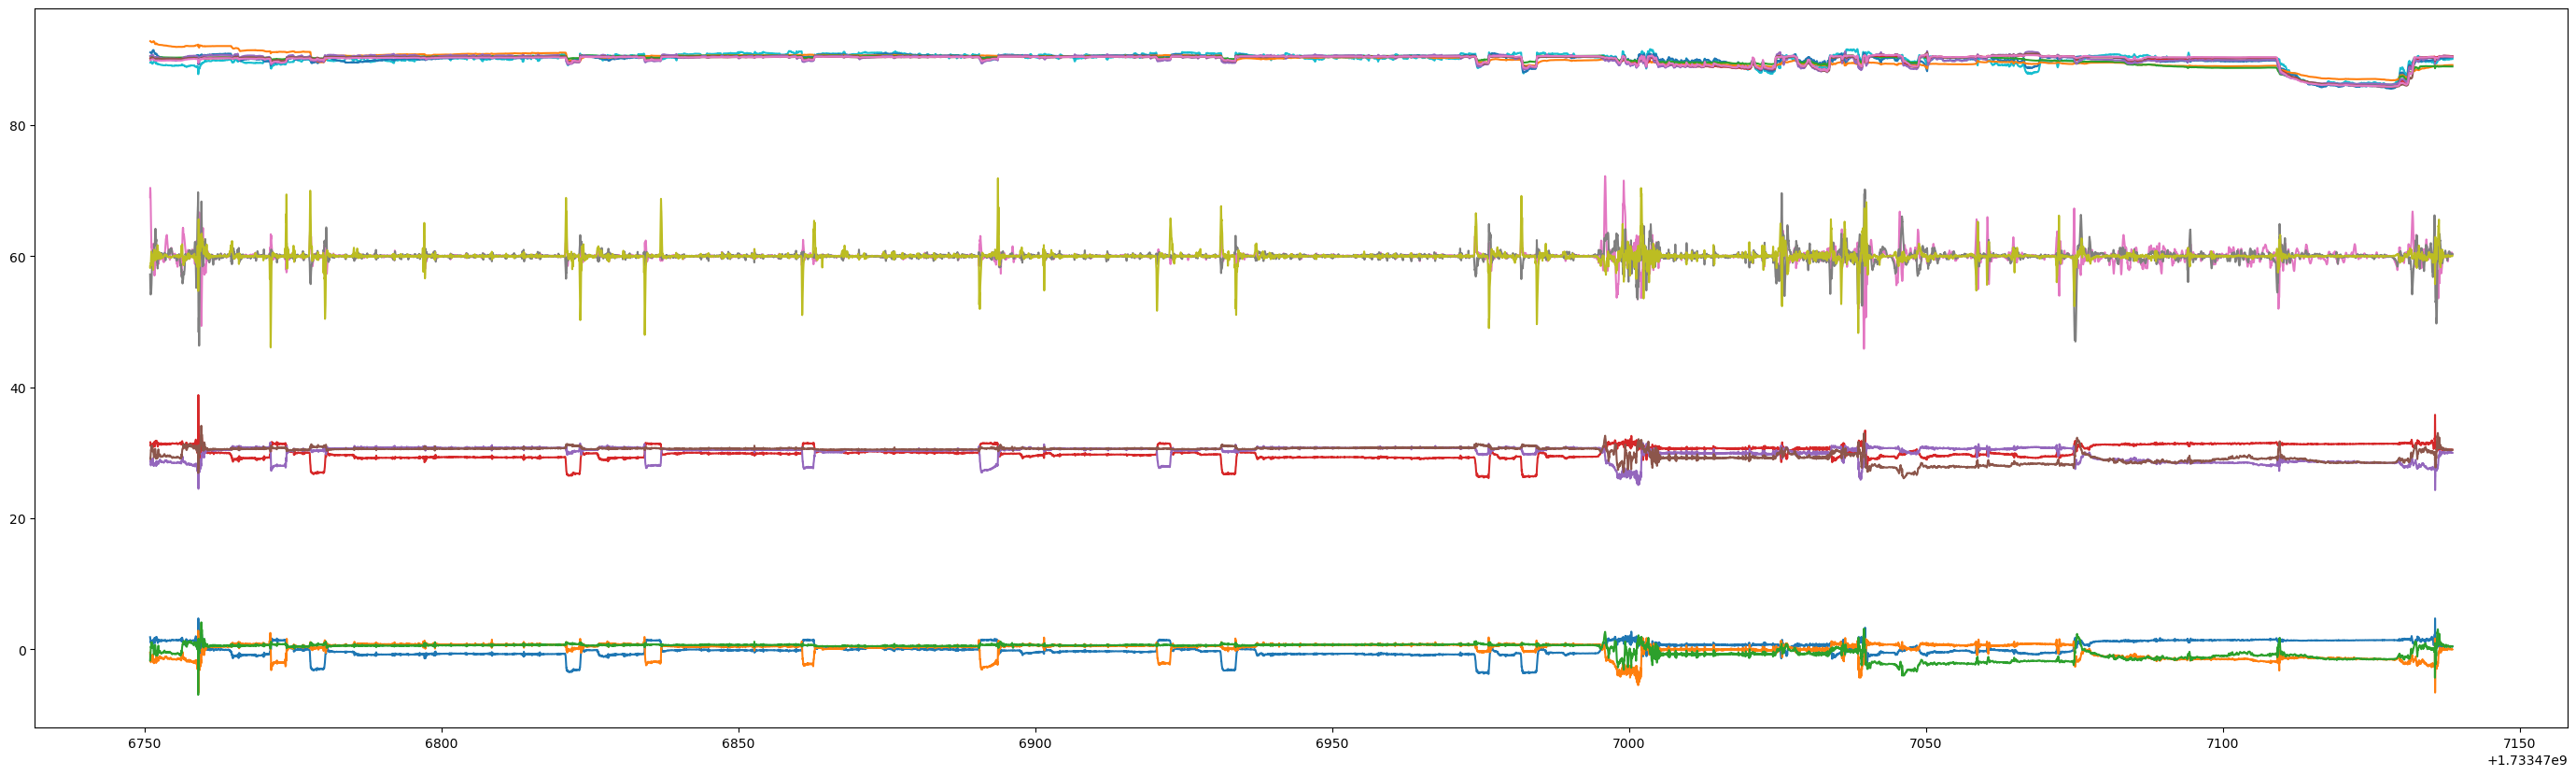

In [1146]:
def normalize_df(df):
    df_new = df.copy()
    for col in df_new.columns:
        df_new.loc[:,col] = (df_new[col] - df_new[col].mean()) / df_new[col].std()
    return df_new

fig, ax = plt.subplots(1, figsize=(35,10))
ax.plot(normalize_df(df_all[["acc_z", "acc_y", "acc_x"]]))
ax.plot(normalize_df(df_all[["acc_ppg_z", "acc_ppg_y", "acc_ppg_x"]]) + 30)
ax.plot(normalize_df(df_all[["gyro_z", "gyro_y", "gyro_x"]]) + 60)
ax.plot(normalize_df(df_all[["ppg_green_1", "ppg_green_2", "ppg_green_3", "ppg_green_4", "ppg_green_5", "ppg_green_6", "ppg_green_7", "ppg_green_8"]]) + 90)

In [1147]:
labels_index = labels_re.copy()

for i, row in labels_re.iterrows():
    label_start = df_all.index[df_all.index > row["start_time"]]
    label_start = label_start[0] if len(label_start) > 0 else df_all.index[-1]
    labels_index.at[i, "start_index"] = df_all.index.get_loc(label_start)
    label_end = df_all.index[df_all.index > row["end_time"]]
    label_end = label_end[0] if len(label_end) > 0 else df_all.index[-1]
    labels_index.at[i, "end_index"] = df_all.index.get_loc(label_end)
    if label_end == label_start and labels_index.at[i, "label"] != "s":
        labels_index.drop(i, inplace=True)
labels_index[["start_index", "end_index"]] = labels_index[["start_index", "end_index"]].astype(int)


In [1148]:
label_neg = labels_index[(labels_index["label"] == "o") & ((labels_index["end_index"] - labels_index["start_index"]) > 300)].iloc[0]

window_size, step_size = 150, 50
time_window_size = window_size / sampling_rate_ppg
s_indices = np.arange(label_neg["start_index"], label_neg["end_index"] - window_size, step_size)
s_times = np.linspace(label_neg["start_time"], label_neg["end_time"] - time_window_size, len(s_indices))

additional_labels = {"start_time": [], "end_time": [],  "label": [], "start_index": [], "end_index": []}

for s_index, s_time in zip(s_indices, s_times):
    e_index = s_index + window_size
    e_time = s_time + time_window_size

    if e_index > len(df_all):
        print(e_index)
        continue

    additional_labels["start_time"].append(s_time)
    additional_labels["end_time"].append(e_time)
    additional_labels["start_index"].append(s_index)
    additional_labels["end_index"].append(e_index)
    additional_labels["label"].append("o")
print(f"Added {len(additional_labels['label'])} additional labels")
labels_index = pd.concat([labels_index, pd.DataFrame(additional_labels)], ignore_index=True)

labels_index = labels_index[~labels_index["start_time"].duplicated(keep="last")]

In [1149]:
df_all.drop(columns=["package_id", "timestamp_computer"], inplace=True)
df_all.reset_index(inplace=True)

assert (labels_index["start_index"] > 0).all()
assert (labels_index["end_index"] < len(df_all)).all()

In [1150]:
drop_count = 0
for i, row in labels_index.iterrows():
    correlation_z = df_all.iloc[row["start_index"]:row["end_index"]][["acc_z", "acc_ppg_z"]].corr().iloc[0,1]
    correlation_x = df_all.iloc[row["start_index"]:row["end_index"]][["acc_x", "acc_ppg_x"]].corr().iloc[0,1]
    correlation_y = df_all.iloc[row["start_index"]:row["end_index"]][["acc_y", "acc_ppg_y"]].corr().iloc[0,1]
    correlation = np.mean([correlation_z, correlation_x, correlation_y])
    if correlation < 0.75:
        #print(f"Bad correlation for {i} with {correlation}")
        # remove that label
        #labels_index.drop(i, inplace=True)
        drop_count += 1

print(f"Dropped {drop_count}/{len(labels_re)} labels due to bad correlation")

Dropped 6/150 labels due to bad correlation


In [1151]:
import h5py

def save_to_hdf5(df_all, labels_df, output_file):
    # Read the labels from a CSV or pandas dataframe

    # Open an HDF5 file
    with h5py.File(output_file, 'w') as hdf5_file:
        # Iterate over each row of the dataframe
        for idx, row in labels_df.iterrows():
            label = row['label']
            start_index = row['start_index']
            end_index = row['end_index']
            start_time = row['start_time']
            end_time = row['end_time']

            # Create a group named 'Label_Timestamp' (label + index)
            group_name = f"{label}_{int(start_time*1000)}"
            label_group = hdf5_file.create_group(group_name)

            # Save the start and end indexes as datasets in the group
            label_group.create_dataset('start_index', data=start_index)
            label_group.create_dataset('end_index', data=end_index)
            label_group.create_dataset('label', data=label)
            label_group.create_dataset('start_time', data=start_time)
            label_group.create_dataset('end_time', data=end_time)
        
        data_group = hdf5_file.create_group("data")
        for column in df_all.columns:
            data_group.create_dataset(column, data=df_all[column].values)

            

    print(f"Labels saved to {output_file}")
    

save_path = os.path.join(save_dir, "participant_"+ participant_name.split("_")[0], f"participant_{participant_name}.hdf5")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
save_to_hdf5(df_all, labels_index, save_path)

Labels saved to C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_alex\participant_alex_2.hdf5


In [664]:
import cv2
import time
import pygame


def show_video_from_frames_pygame(frames, fps=30):
    """
    Displays video frames using PyGame, overlays frame IDs, and maintains specified FPS.
    
    Args:
        frames (list): List of video frames (BGR format).
        fps (int): Frames per second for playback.
    
    Returns:
        bool: True if the video plays without interruption; False if 'q' is pressed to quit.
    """
    # Initialize PyGame
    pygame.init()
    clock = pygame.time.Clock()

    # Set up the display window
    frame_height, frame_width = frames[0][0].shape[:2]
    screen = pygame.display.set_mode((frame_width, frame_height))
    pygame.display.set_caption("Video Playback")

    running = True
    for frame_id, frame in enumerate(frames):
        
        frame = frame[0]
        # Handle events (exit on quit or 'q' key)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN and event.key == pygame.K_q:
                running = False
        
        if not running:
            break

        # Convert the frame from BGR (OpenCV format) to RGB (PyGame format)
        frame_rgb = frame

        # Overlay the frame ID on the frame
        text = f"Frame: {frame_id}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (200, 30)
        font_scale = 1
        font_color = (255, 255, 255)  # White
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(frame_rgb, text, position, font, font_scale, font_color, thickness, line_type)

        # Convert frame to a surface for PyGame
        frame_surface = pygame.surfarray.make_surface(np.transpose(frame_rgb, (1,0,2)))

        # Display the frame on the PyGame window
        screen.blit(frame_surface, (0, 0))
        pygame.display.flip()

        # Wait to maintain the desired FPS
        clock.tick(fps)

    # Quit PyGame
    pygame.quit()
    return running


    
def plot_frame(frame):
    
    if isinstance(frame, tuple):
        frame = frame[0]
    
    # Convert BGR to RGB
    frame_rgb = frame
    
    # Plot the frame
    plt.imshow(frame_rgb)
    plt.axis('off')  # Optional: turn off axis
    plt.show()

def load_video(video_file):
    
    cap = cv2.VideoCapture(video_file)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames



def load_specific_frames(video_file, frame_indices):
    import cv2
    cap = cv2.VideoCapture(video_file)
    frames = []
    
    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in frame_indices:
        if i < total_frames:
            # Set the video position to the specific frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frames.append(frame)
    
    cap.release()
    return frames

def show_video_from_frames_pygame(frames, fps=30, track_key=pygame.K_p, post_release_frames=3, gesture = ""):
    """
    Displays video frames using PyGame, overlays frame IDs, and maintains specified FPS.
    Detects when a specific key is pressed and released, and records the corresponding frame indices.
    Plays for a specified number of frames after key release.
    
    Args:
        frames (list): List of video frames (BGR format).
        fps (int): Frames per second for playback.
        track_key (int): Key to track for press/release detection (default: pygame.K_p).
        post_release_frames (int): Number of frames to play after key release.
    
    Returns:
        list: List of tuples (pressed_frame, released_frame) indicating key press/release frame indices.
    """
    # Initialize PyGame
    pygame.init()
    clock = pygame.time.Clock()

    if len(frames) == 0:
        print("No frames to display.")
        return None

    # Set up the display window
    frame_height, frame_width = frames[0][0].shape[:2]
    screen = pygame.display.set_mode((frame_width, frame_height))
    pygame.display.set_caption("Video Playback")

    running = True
    pressed_frame = None
    released_frame = None
    key_events = []  # List to store (pressed_frame, released_frame) tuples
    continue_frames = 0  # Counter for post-release playback

    #for frame_id, frame in enumerate(frames):
    frame_id = 0
    while frame_id < len(frames):
        frame, frame_time = frames[frame_id]  # Unpack if frame is tuple

        # Handle events (exit on quit or 'q' key, track key press/release)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:  # Exit on 'q'
                    running = False
                elif event.key == pygame.K_d: #discard key
                    running = False
                    key_events = -1
                elif event.key == pygame.K_r: #repeat key
                    running = False
                    key_events = -2
                elif event.key == track_key:  # Track key press
                    if pressed_frame is None:  # Start of a press
                        pressed_frame = frame_time
            if event.type == pygame.KEYUP and event.key == track_key:  # Track key release
                if pressed_frame is not None:
                    released_frame = frame_time
                    key_events.append((pressed_frame, released_frame))
                    pressed_frame = None  # Reset after release
                    continue_frames = post_release_frames  # Enable post-release playback
        
        if not running:
            break

        # Continue playing for post-release frames
        if continue_frames > 0:
            continue_frames -= 1
            if continue_frames == 0:
                break  # Stop playback after post-release frames

        # Convert the frame from BGR (OpenCV format) to RGB (PyGame format)
        frame_rgb = frame

        # Overlay the frame ID on the frame
        text = f"Frame: {frame_id}   Gesture: {gesture}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (200, 30)
        font_scale = 1
        font_color = (255, 255, 255)  # White
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(frame_rgb, text, position, font, font_scale, font_color, thickness, line_type)

        # Convert frame to a surface for PyGame
        frame_surface = pygame.surfarray.make_surface(np.transpose(frame_rgb, (1, 0, 2)))

        # Display the frame on the PyGame window
        screen.blit(frame_surface, (0, 0))
        pygame.display.flip()

        # Wait to maintain the desired FPS
        clock.tick(fps)
        
        frame_id += 1

    # Quit PyGame
    pygame.quit()
    return key_events



In [665]:
def add_manual_labels(labels, data_path, video_file, specify_gestures:list = [], fps=3, delay_frames=0, frame_offset=20):

    if specify_gestures:
        pinch_labels = labels[labels["label"].isin(specify_gestures)]
    else:
        pinch_labels = labels
    
    pinch_labels.sort_values(by=["label", "start_time"], inplace=True)
    new_labels = labels.copy()
        
    i = 0
    while i < len(pinch_labels):
    
        gesture_index = pinch_labels.index[i]
        row = pinch_labels.loc[gesture_index]
        
        video_frames = load_frames_by_time_range(os.path.join(data_path, video_file), row["start_time"], row["end_time"] + 0.5, delay_frames=delay_frames, offset = frame_offset)
        
        gesture_frame = show_video_from_frames_pygame(video_frames, fps=fps, gesture=row["label"])
            
        if not gesture_frame:
            i += 1
            continue
        
        if isinstance(gesture_frame, int) and gesture_frame == -1:
            print(f"Discarding label {i}: {row['label']} from {row['start_time']} to {row['end_time']}")
            new_labels.drop(gesture_index, inplace=True)
            i += 1
            continue
        
        elif isinstance(gesture_frame, int) and gesture_frame == -2:
            print(f"Repeating label {i}: {row['label']} from {row['start_time']} to {row['end_time']}")
            i -= 1
            continue
        
        gesture_time_start, gesture_time_end = gesture_frame[0]

        print(f"Corrected Start Time by {row['start_time'] - gesture_time_start} and End Time by {row['end_time'] - gesture_time_end}")
        new_labels.at[gesture_index, "start_time"] = gesture_time_start
        new_labels.at[gesture_index, "end_time"] = gesture_time_end
        
        i += 1
        
        
    return new_labels

In [38]:
def show_video_from_frames_pygame(frames, fps=30, track_key=pygame.K_p, post_release_frames=3, gesture = ""):
    """
    Displays video frames using PyGame, overlays frame IDs, and maintains specified FPS.
    Detects when a specific key is pressed and released, and records the corresponding frame indices.
    Plays for a specified number of frames after key release.
    
    Args:
        frames (list): List of video frames (BGR format).
        fps (int): Frames per second for playback.
        track_key (int): Key to track for press/release detection (default: pygame.K_p).
        post_release_frames (int): Number of frames to play after key release.
    
    Returns:
        list: List of tuples (pressed_frame, released_frame) indicating key press/release frame indices.
    """
    # Initialize PyGame
    pygame.init()
    clock = pygame.time.Clock()

    if len(frames) == 0:
        print("No frames to display.")
        return None

    # Set up the display window
    frame_height, frame_width = frames[0][0].shape[:2]
    screen = pygame.display.set_mode((frame_width, frame_height))
    pygame.display.set_caption("Video Playback")

    running = True
    pressed_frame = None
    released_frame = None
    key_events = []  # List to store (pressed_frame, released_frame) tuples
    continue_frames = 0  # Counter for post-release playback

    #for frame_id, frame in enumerate(frames):
    frame_id = 0
    while frame_id < len(frames):
        frame, frame_time = frames[frame_id]  # Unpack if frame is tuple

        # Handle events (exit on quit or 'q' key, track key press/release)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:  # Exit on 'q'
                    running = False
                elif event.key == pygame.K_d: #discard key
                    running = False
                    key_events = -1
                elif event.key == pygame.K_r: #repeat key
                    running = False
                    key_events = -2
                elif event.key == track_key:  # Track key press
                    if pressed_frame is None:  # Start of a press
                        pressed_frame = frame_time
            if event.type == pygame.KEYUP and event.key == track_key:  # Track key release
                if pressed_frame is not None:
                    released_frame = frame_time
                    key_events.append((pressed_frame, released_frame))
                    pressed_frame = None  # Reset after release
                    continue_frames = post_release_frames  # Enable post-release playback
        
        if not running:
            break

        # Continue playing for post-release frames
        if continue_frames > 0:
            continue_frames -= 1
            if continue_frames == 0:
                break  # Stop playback after post-release frames

        # Convert the frame from BGR (OpenCV format) to RGB (PyGame format)
        #frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_rgb = frame
        # Overlay the frame ID on the frame
        text = f"Frame: {frame_id}   Gesture: {gesture}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (200, 30)
        font_scale = 1
        font_color = (255, 255, 255)  # White
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(frame_rgb, text, position, font, font_scale, font_color, thickness, line_type)

        # Convert frame to a surface for PyGame
        frame_surface = pygame.surfarray.make_surface(np.transpose(frame_rgb, (1, 0, 2)))

        # Display the frame on the PyGame window
        screen.blit(frame_surface, (0, 0))
        pygame.display.flip()

        # Wait to maintain the desired FPS
        clock.tick(fps)
        
        frame_id += 1

    # Quit PyGame
    pygame.quit()
    return key_events



def load_frames_by_time_range(video_file, start_timestamp, end_timestamp, offset=0, delay_frames=0):
    cap = cv2.VideoCapture(video_file)
    frames = []
    
    timestamps_file = video_file.replace(".avi", "_timestamps.txt")
    start_time, end_time = None, None
    for line in open(timestamps_file, "r").readlines():
        if line.startswith("Recording Start Time:"):
            start_time = float(line.split(":")[-1])
        if line.startswith("Recording End Time:"):
            end_time = float(line.split(":")[-1])
    
    assert start_time is not None and end_time is not None, "Could not read start and end time from file"
    
    # Get video FPS and total number of frames
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate delay time and adjust start and end timestamps
    delay_time = delay_frames * 1 / fps  # Delay in seconds
    start_time += delay_time
    end_time += delay_time

    # Calculate the start and end frame indices
    start_frame = int((start_timestamp - start_time) * fps) + offset
    end_frame = int((end_timestamp - start_time) * fps) + offset

    # Ensure the frame indices are within bounds
    start_frame = max(0, start_frame)
    end_frame = min(total_frames, end_frame)

    # Seek to the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Read frames sequentially
    for frame_index in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break  # Stop if we can't read the frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_time = start_time + frame_index / fps
        frames.append((frame, frame_time))
    
    cap.release()
    return frames